In [27]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from PIL import Image
import os
import pandas as pd
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
from tqdm import tqdm
from torchinfo import summary as tsummary
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cpu


# Prep DATASET

In [18]:
class SeqDataset(Dataset):
    def __init__(self, csv_path, seq_root, seq_len=30, transform=None, augment=False):
        self.df = pd.read_csv(csv_path)
        self.seq_root = seq_root
        self.seq_len = seq_len
        self.transform = transform
        self.augment = augment

        self.color_aug = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02
        )

    def __len__(self):
        return len(self.df)

    def augment_sequence(self, frames):
        if random.random() < 0.5:
            frames = [cv2.flip(f, 1) for f in frames]
        # rotation
        if random.random() < 0.3:
            angle = random.uniform(-5, 5)
            h, w = frames[0].shape[:2]
            M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
            frames = [cv2.warpAffine(f, M, (w, h)) for f in frames]

        # noise
        if random.random() < 0.3:
            noise = np.random.normal(0, 4, frames[0].shape).astype(np.uint8)
            frames = [cv2.add(f, noise) for f in frames]

        # color jitter
        if random.random() < 0.3:
            frames_pil = [transforms.ToPILImage()(f) for f in frames]
            frames_pil = [self.color_aug(im) for im in frames_pil]
            frames = [np.array(im) for im in frames_pil]

        return frames

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq_name = row["sequence"]
        label = row["label"]

        seq_dir = os.path.join(self.seq_root, seq_name)

        frames = []
        for i in range(1, self.seq_len + 1):
            img_path = os.path.join(seq_dir, f"{i:05d}.jpg")
            img = cv2.imread(img_path)

            if img is None:
                raise FileNotFoundError(f"Missing frame: {img_path}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frames.append(img)

        # apply augmentation
        if self.augment:
            frames = self.augment_sequence(frames)

        # apply transform to each frame
        if self.transform:
            frames = [self.transform(f) for f in frames]
        else:
            frames = [transforms.ToTensor()(f) for f in frames]

        frames = torch.stack(frames, dim=0)  # (T, C, H, W)

        return frames, torch.tensor(label, dtype=torch.float32)

In [19]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ## imgnet stats
])


train_dataset = SeqDataset(
    csv_path = "Data/train/train.csv",
    seq_root = "Data/train/sequences",
    seq_len=30,
    transform=transform,
    augment=False
)
val_dataset = SeqDataset(
    csv_path = "Data/validation/validation.csv",
    seq_root = "Data/validation/sequences",
    seq_len=30,
    transform=transform,
    augment=False
)

test_dataset = SeqDataset(
    csv_path = "Data/test/test.csv",
    seq_root = "Data/test/sequences",
    seq_len=30,
    transform=transform,
    augment=False
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 618
Number of validation samples: 256
Number of test samples: 116


In [20]:
def print_label_stats(csv_path, name="DATASET"):
    df = pd.read_csv(csv_path)

    print(f"\n===== {name} label distribution =====")
    print(df["label"].value_counts())

    print("\n===== Percentage (%) =====")
    print((df["label"].value_counts(normalize=True) * 100).round(2))

    print("\nTotal samples:", len(df))

train_csv = "Data/train/train.csv"
val_csv   = "Data/validation/validation.csv"
test_csv  = "Data/test/test.csv"

print_label_stats(train_csv, "TRAIN")
print_label_stats(val_csv, "VALIDATION")
print_label_stats(test_csv, "TEST")


===== TRAIN label distribution =====
label
0    425
1    193
Name: count, dtype: int64

===== Percentage (%) =====
label
0    68.77
1    31.23
Name: proportion, dtype: float64

Total samples: 618

===== VALIDATION label distribution =====
label
0    151
1    105
Name: count, dtype: int64

===== Percentage (%) =====
label
0    58.98
1    41.02
Name: proportion, dtype: float64

Total samples: 256

===== TEST label distribution =====
label
0    73
1    43
Name: count, dtype: int64

===== Percentage (%) =====
label
0    62.93
1    37.07
Name: proportion, dtype: float64

Total samples: 116


# DEFINE MODEL

### ResNet + LSTM + FC

In [21]:
class RES_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, dropout= 0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        RES = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for p in RES.parameters():
            p.requires_grad = False

        modules = list(RES.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feat = self.cnn(x)
        feat = feat.view(B, T, 512)

        out, _ = self.lstm(feat)
        seq_feature = torch.mean(out, dim=1)
        logit = self.fc(seq_feature)
        return logit

    

# Define func Train / Evaludate

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for (x, y) in tqdm(loader, desc="Training", leave=True):
        x = x.to(device)
        y = y.to(device).float() # label is int so convert to float

        optimizer.zero_grad()
        logits = model(x).squeeze(1)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += batch_size

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for (x, y) in tqdm(loader, desc="Evaluating", leave=True):
        x = x.to(device)
        y = y.to(device).float()

        logits = model(x).squeeze(1)

        loss = criterion(logits, y)

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += batch_size

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate_test(model, loader, criterion, device):
    model.eval()
    
    all_labels = []
    all_preds  = []
    total_loss = 0
    total = 0

    for (sequences, labels) in tqdm(loader, desc="Testing", leave=True):
        sequences = sequences.to(device)
        labels = labels.to(device).float()

        outputs = model(sequences).squeeze(1)

        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        total += labels.size(0)

        preds = (torch.sigmoid(outputs) >= 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / total
    acc  = (np.array(all_labels) == np.array(all_preds)).mean()
    f1   = f1_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)

    return avg_loss, acc, f1, prec, rec

In [23]:
model = RES_LSTM(hidden_size=128, num_layers=2, dropout=0.3) # (256, 2) - (64, 1)
model = model.to(device)

tsummary(model, input_size=(1, 30, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
RES_LSTM                                      [1, 1]                    --
├─Sequential: 1-1                             [30, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [30, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [30, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [30, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [30, 64, 56, 56]          --
│    └─Sequential: 2-5                        [30, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [30, 64, 56, 56]          (73,984)
│    │    └─BasicBlock: 3-2                   [30, 64, 56, 56]          (73,984)
│    └─Sequential: 2-6                        [30, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [30, 128, 28, 28]         (230,144)
│    │    └─BasicBlock: 3-4                   [30, 128, 28, 28]     

In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 20

best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []
counter = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    counter += 1
    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.3f}, Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.3f}, Acc: {val_acc*100:.2f}%" )
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss: # Early Stopping
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("improved")
    else:
        patience_counter += 1
        print("not improved")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Evaluating: 100%|██████████| 64/64 [02:36<00:00,  2.45s/it]


Epoch 01 | Train Loss: 0.625, Acc: 68.28% | Val Loss: 0.597, Acc: 58.98%
improved


Evaluating: 100%|██████████| 64/64 [02:34<00:00,  2.41s/it]


Epoch 02 | Train Loss: 0.530, Acc: 74.60% | Val Loss: 0.533, Acc: 73.44%
improved


Evaluating: 100%|██████████| 64/64 [02:35<00:00,  2.43s/it]


Epoch 03 | Train Loss: 0.481, Acc: 77.35% | Val Loss: 0.500, Acc: 73.44%
improved


Evaluating: 100%|██████████| 64/64 [02:37<00:00,  2.46s/it]


Epoch 04 | Train Loss: 0.456, Acc: 77.51% | Val Loss: 0.485, Acc: 73.83%
improved


Evaluating: 100%|██████████| 64/64 [02:28<00:00,  2.33s/it]


Epoch 05 | Train Loss: 0.461, Acc: 77.99% | Val Loss: 0.466, Acc: 76.56%
improved


Evaluating: 100%|██████████| 64/64 [02:31<00:00,  2.37s/it]


Epoch 06 | Train Loss: 0.431, Acc: 78.32% | Val Loss: 0.450, Acc: 76.56%
improved


Evaluating: 100%|██████████| 64/64 [1:17:26<00:00, 72.61s/it]   


Epoch 07 | Train Loss: 0.450, Acc: 77.99% | Val Loss: 0.455, Acc: 75.39%
not improved


Evaluating: 100%|██████████| 64/64 [02:32<00:00,  2.38s/it]


Epoch 08 | Train Loss: 0.422, Acc: 79.45% | Val Loss: 0.490, Acc: 76.17%
not improved


Evaluating: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it]


Epoch 09 | Train Loss: 0.430, Acc: 78.32% | Val Loss: 0.437, Acc: 80.86%
improved


Evaluating: 100%|██████████| 64/64 [02:32<00:00,  2.39s/it]


Epoch 10 | Train Loss: 0.403, Acc: 81.23% | Val Loss: 0.422, Acc: 79.69%
improved


Evaluating: 100%|██████████| 64/64 [02:44<00:00,  2.57s/it]


Epoch 11 | Train Loss: 0.391, Acc: 82.52% | Val Loss: 0.481, Acc: 74.22%
not improved


Evaluating: 100%|██████████| 64/64 [02:33<00:00,  2.39s/it]


Epoch 12 | Train Loss: 0.402, Acc: 80.58% | Val Loss: 0.414, Acc: 84.38%
improved


Evaluating: 100%|██████████| 64/64 [02:33<00:00,  2.39s/it]


Epoch 13 | Train Loss: 0.393, Acc: 80.91% | Val Loss: 0.415, Acc: 83.98%
not improved


Evaluating: 100%|██████████| 64/64 [02:35<00:00,  2.43s/it]


Epoch 14 | Train Loss: 0.417, Acc: 80.58% | Val Loss: 0.464, Acc: 76.95%
not improved


Evaluating: 100%|██████████| 64/64 [02:33<00:00,  2.40s/it]


Epoch 15 | Train Loss: 0.389, Acc: 82.04% | Val Loss: 0.524, Acc: 76.95%
not improved


Evaluating: 100%|██████████| 64/64 [02:33<00:00,  2.39s/it]


Epoch 16 | Train Loss: 0.361, Acc: 84.14% | Val Loss: 0.543, Acc: 74.22%
not improved


Evaluating: 100%|██████████| 64/64 [02:33<00:00,  2.40s/it]

Epoch 17 | Train Loss: 0.403, Acc: 80.42% | Val Loss: 0.445, Acc: 81.25%
not improved
Early stopping triggered!


In [36]:
model.load_state_dict(torch.load("best_model.pth"))

avg_loss,acc, f1, prec, rec = evaluate_test(model, test_loader, criterion, device)

print("===== Test Metrics =====")
print(f"Avg Loss: {avg_loss:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

Testing: 100%|██████████| 29/29 [01:19<00:00,  2.73s/it]

===== Test Metrics =====
Avg Loss: 0.3646
Accuracy:  0.8621
F1 Score:  0.8095
Precision: 0.8293
Recall:    0.7907


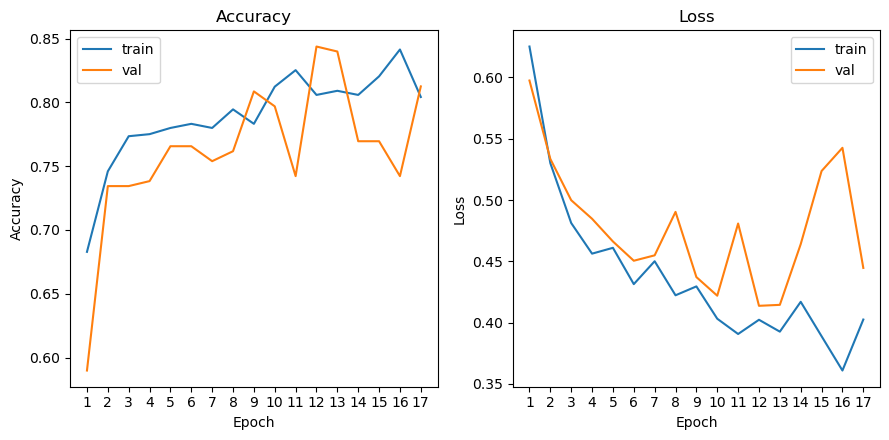

In [37]:

epochs_ax = range(1, counter + 1)

plt.figure(figsize=(9, 4.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_ax, train_accuracies, label='train')
plt.plot(epochs_ax, val_accuracies, label='val')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.xticks(list(epochs_ax))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_ax, train_losses, label='train')
plt.plot(epochs_ax, val_losses, label='val')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.xticks(list(epochs_ax))
plt.legend()
plt.tight_layout()
plt.show()
